In [1]:
import pandas as pd
import mysql.connector

# ✅ CSV 파일 경로
file_path = "/home/kbj/Downloads/2024 자치구별 소득평균.csv"

# ✅ CSV 불러오기
df = pd.read_csv(file_path)

# ✅ 컬럼명 영어로 변경
df.columns = ['gu_name', 'avg_monthly_income']

# ✅ MySQL 연결
conn = mysql.connector.connect(
    host="jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
    user="root",
    password="jinhyuk2dacibul",
    database="project1"
)
cursor = conn.cursor()

# ✅ 테이블 생성 (기존에 있다면 DROP)
cursor.execute("DROP TABLE IF EXISTS income_avg_gu")
cursor.execute("""
CREATE TABLE income_avg_gu (
    gu_name VARCHAR(20),
    avg_monthly_income INT
)
""")

# ✅ 데이터 삽입
for _, row in df.iterrows():
    cursor.execute(
        "INSERT INTO income_avg_gu (gu_name, avg_monthly_income) VALUES (%s, %s)",
        (row['gu_name'], int(row['avg_monthly_income']))
    )

# ✅ 커밋 및 종료
conn.commit()
cursor.close()
conn.close()

print("✅ 데이터가 'income_avg_gu' 테이블에 성공적으로 삽입되었습니다.")


✅ 데이터가 'income_avg_gu' 테이블에 성공적으로 삽입되었습니다.


/tmp/ipykernel_46989/2435300067.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/tmp/ipykernel_46989/2435300067.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="avg_monthly_income", y="gu_name", palette="YlGnBu")


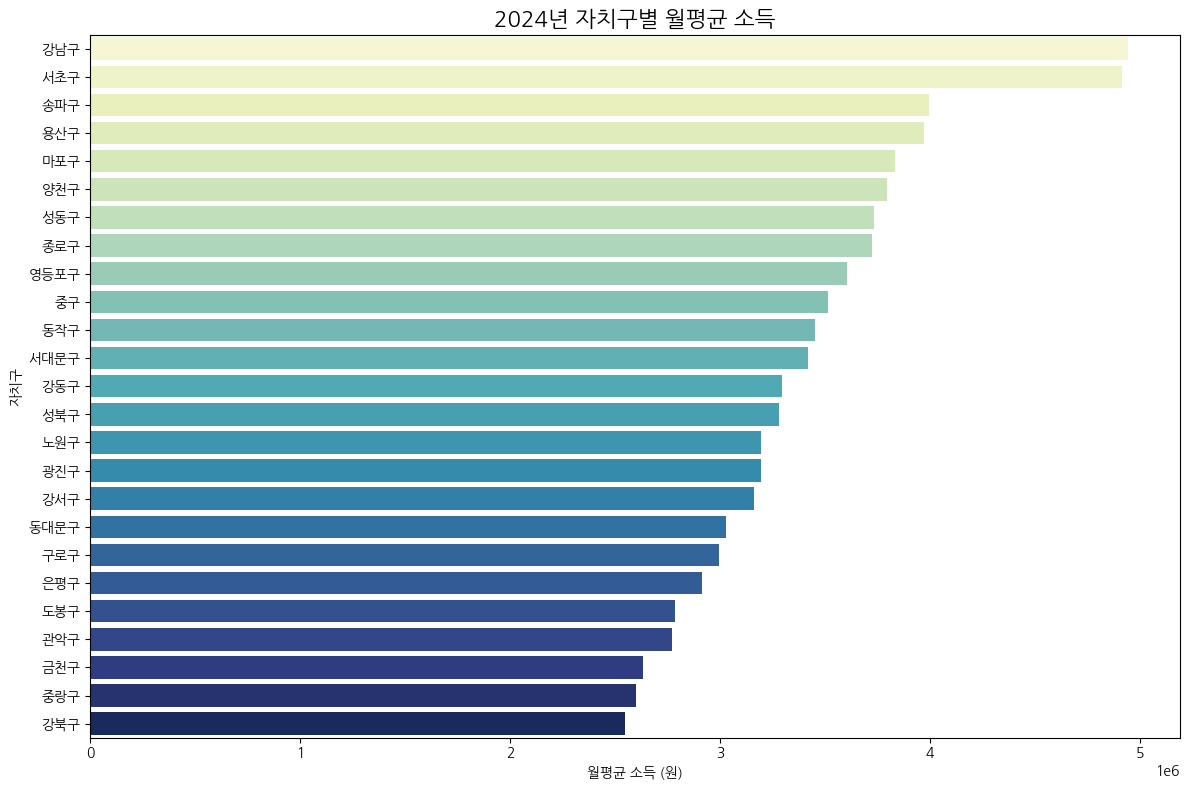

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib  # 한글 폰트 자동 설정

# ✅ MySQL 연결
conn = mysql.connector.connect(
    host="jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
    user="root",
    password="jinhyuk2dacibul",
    database="project1"
)

# ✅ 데이터 불러오기
query = "SELECT gu_name, avg_monthly_income FROM income_avg_gu"
df = pd.read_sql(query, conn)
conn.close()

# ✅ 소득 순으로 정렬
df = df.sort_values(by="avg_monthly_income", ascending=False)

# ✅ 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x="avg_monthly_income", y="gu_name", palette="YlGnBu")

plt.title("2024년 자치구별 월평균 소득", fontsize=16)
plt.xlabel("월평균 소득 (원)")
plt.ylabel("자치구")
plt.tight_layout()
plt.show()


/tmp/ipykernel_46989/4010371898.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_income = pd.read_sql(query_income, conn)
/tmp/ipykernel_46989/4010371898.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rental = pd.read_sql(query_rental, conn)


📌 상관계수 (Pearson r): 0.1674


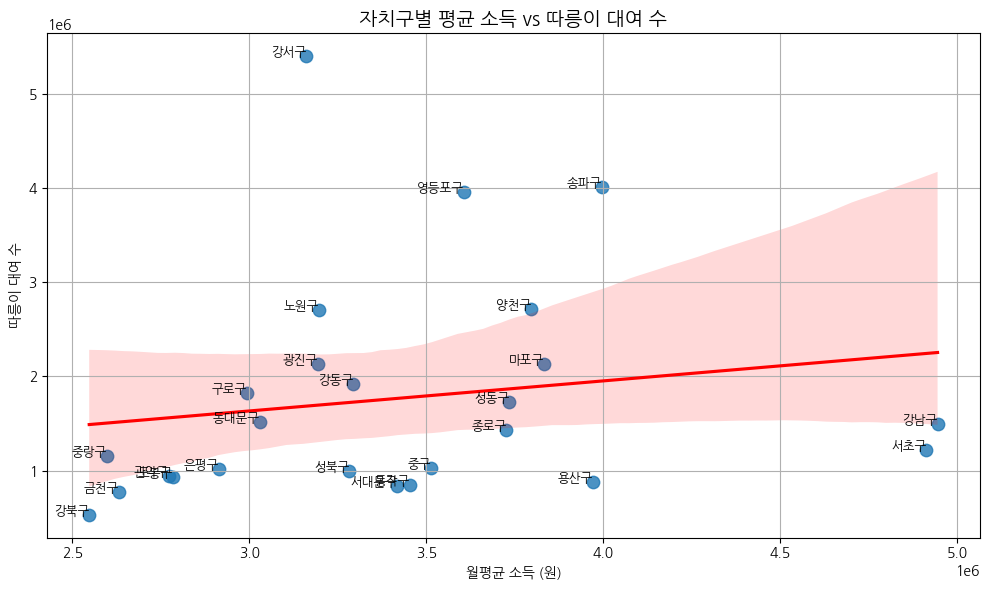

In [10]:
from scipy.stats import pearsonr


# ✅ MySQL 연결
conn = mysql.connector.connect(
    host="jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
    user="root",
    password="jinhyuk2dacibul",
    database="project1"
)

# ✅ 평균 소득 데이터
query_income = "SELECT gu_name, avg_monthly_income FROM income_avg_gu"
df_income = pd.read_sql(query_income, conn)

# ✅ 따릉이 대여 수 데이터 (자치구별 총합)
query_rental = """
SELECT station_gu AS gu_name, SUM(rental_count) AS total_rentals
FROM rental_net_hourly_gu
GROUP BY station_gu
"""
df_rental = pd.read_sql(query_rental, conn)

conn.close()

# ✅ 병합
merged = pd.merge(df_income, df_rental, on="gu_name")

# ✅ 상관계수 계산
corr, _ = pearsonr(merged["avg_monthly_income"], merged["total_rentals"])
print(f"📌 상관계수 (Pearson r): {corr:.4f}")

# ✅ 시각화
plt.figure(figsize=(10, 6))
sns.regplot(
    data=merged,
    x="avg_monthly_income",
    y="total_rentals",
    scatter_kws={"s": 80},
    line_kws={"color": "red"}
)

for i in range(len(merged)):
    plt.text(
        merged["avg_monthly_income"][i],
        merged["total_rentals"][i],
        merged["gu_name"][i],
        fontsize=9,
        ha='right'
    )

plt.title(f"자치구별 평균 소득 vs 따릉이 대여 수", fontsize=14)
plt.xlabel("월평균 소득 (원)")
plt.ylabel("따릉이 대여 수")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine

# ✅ 데이터 불러오기
df_income_dong = pd.read_csv("/home/kbj/Downloads/2024 행정동별 소득평균.csv")
df_income_dong.columns = ["dong_name", "avg_income"]  # 컬럼명 영어로 변경

# ✅ SQLAlchemy 엔진 설정
user = "root"
password = "jinhyuk2dacibul"
host = "jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com"
database = "project1"
engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}/{database}")

# ✅ 테이블로 업로드
df_income_dong.to_sql("income_avg_dong", con=engine, if_exists="replace", index=False)

print("✅ income_avg_dong 테이블로 업로드 완료")


✅ income_avg_dong 테이블로 업로드 완료


In [13]:
import pandas as pd
import mysql.connector

# ✅ MySQL 연결
conn = mysql.connector.connect(
    host="jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
    user="root",
    password="jinhyuk2dacibul",
    database="project1"
)

# ✅ station 테이블 불러오기
df_station = pd.read_sql("SELECT * FROM station", conn)

# ✅ CSV로 저장
df_station.to_csv("station_table.csv", index=False, encoding="utf-8-sig")

print("✅ 'station_table.csv' 파일로 저장 완료")

conn.close()


✅ 'station_table.csv' 파일로 저장 완료


/tmp/ipykernel_46989/705469167.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_station = pd.read_sql("SELECT * FROM station", conn)


/tmp/ipykernel_57219/3210284989.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_income = pd.read_sql("SELECT * FROM income_avg_dong", conn)
/tmp/ipykernel_57219/3210284989.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rental = pd.read_sql("SELECT * FROM rental_station", conn)
/tmp/ipykernel_57219/3210284989.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_station = pd.read_sql("SELECT station_id, station_gu, station_dong FROM station_b", conn)


📌 상관계수 (r): 0.18


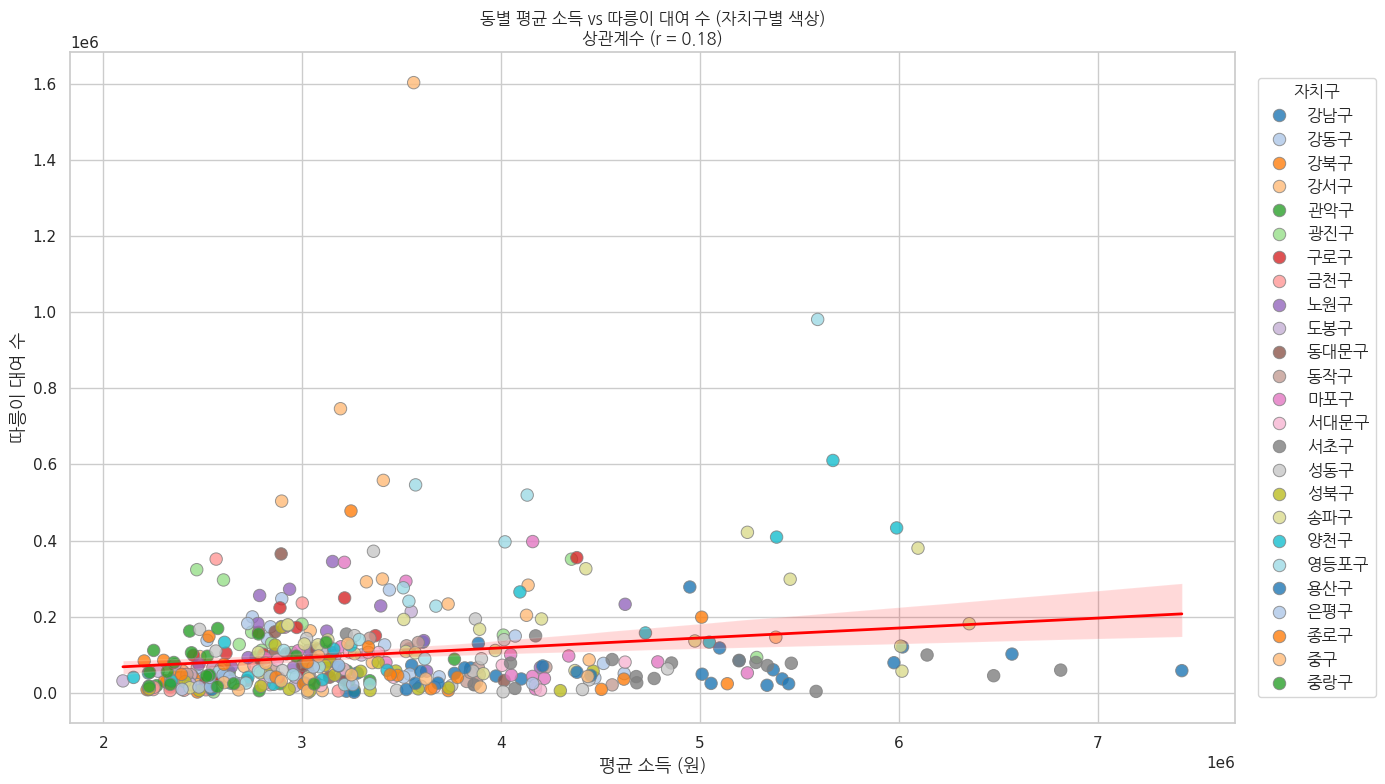

In [2]:


# ✅ 나눔고딕 폰트 설정
font_path = "/home/kbj/Downloads/godic/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# ✅ DB 연결
conn = mysql.connector.connect(
    host="jinhyuk2db.c94oygiiukcg.ap-northeast-2.rds.amazonaws.com",
    user="root",
    password="jinhyuk2dacibul",
    database="project1"
)

# ✅ 데이터 불러오기
df_income = pd.read_sql("SELECT * FROM income_avg_dong", conn)
df_rental = pd.read_sql("SELECT * FROM rental_station", conn)
df_station = pd.read_sql("SELECT station_id, station_gu, station_dong FROM station_b", conn)
conn.close()

# ✅ 대여소 + 위치 매핑
df_merge = pd.merge(df_rental, df_station, left_on="rental_station_id", right_on="station_id")

# ✅ 동별 따릉이 대여량 집계
df_rental_by_dong = df_merge.groupby(["station_gu", "station_dong"])["total_rental_count"].sum().reset_index()
df_rental_by_dong.columns = ["gu_name", "dong_name", "total_rental_count"]

# ✅ 평균소득 테이블과 병합
df_all = pd.merge(df_rental_by_dong, df_income, on="dong_name")

# ✅ 상관계수
corr, _ = pearsonr(df_all["avg_income"], df_all["total_rental_count"])
print(f"📌 상관계수 (r): {corr:.2f}")

# ✅ 시각화 스타일
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

# ✅ 산점도 (자치구별 색상), 회귀선 포함
sns.scatterplot(
    data=df_all,
    x="avg_income",
    y="total_rental_count",
    hue="gu_name",
    palette="tab20",
    s=80,
    alpha=0.8,
    edgecolor="gray"
)

# ✅ 전체 회귀선
sns.regplot(
    data=df_all,
    x="avg_income",
    y="total_rental_count",
    scatter=False,
    color="red",
    line_kws={"linewidth": 2}
)

# ✅ 타이틀 및 축
plt.title(f"동별 평균 소득 vs 따릉이 대여 수 (자치구별 색상)\n상관계수 (r = {corr:.2f})",
          fontsize=16, fontweight="bold", fontproperties=font_prop)
plt.xlabel("평균 소득 (원)", fontsize=13, fontproperties=font_prop)
plt.ylabel("따릉이 대여 수", fontsize=13, fontproperties=font_prop)

# ✅ 범례 오른쪽 + 한글 적용
legend = plt.legend(title="자치구", bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0.)
legend.get_title().set_fontproperties(font_prop)
for text in legend.get_texts():
    text.set_fontproperties(font_prop)

plt.tight_layout()
plt.show()
